1.Remove or otherwise handle movies with few ratings. A movie with less than a certain threshold number of ratings will likely fail to develop appropriate features.
2.Separate into training, test, cross-validation sets.
3.Restructuring the existing data set from a list of user ID, movie ID, and ratings to a matrix containing the ratings from a user for a specific movie.
4.Apply mean normalization to all of the ratings by movie.
5.Initialize random features for users and movies - size will be selected based on cross-validation accuracy.
6.Applying a collaborative filtering algorithm with gradient descent should be able to resolve features for both the movies and the users.
7.Use features to form recommendations by either predicting a user’s rating or determining similarity between movies.

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.cross_validation import train_test_split
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [25]:
ratings = pd.DataFrame.from_csv('ratings.csv',index_col=None)
movies = pd.DataFrame.from_csv('movies.csv',index_col='movieId')
ratings.rating = ratings.rating.astype('float16')
ratings.userId = ratings.userId.astype('int32')
ratings.movieId = ratings.movieId.astype('int32')

645    20
58     20
497    20
313    20
350    20
Name: userId, dtype: int64

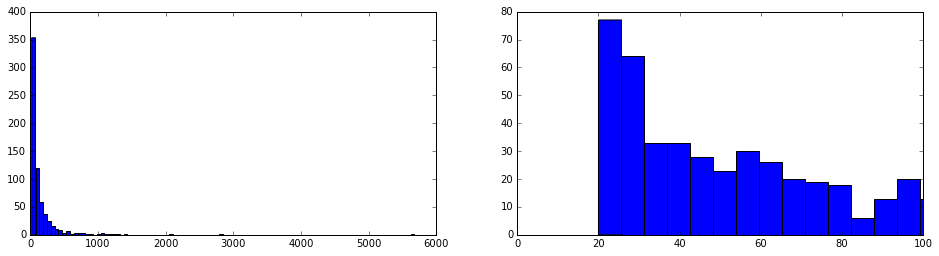

In [26]:
fig, axes = plt.subplots(1,2,figsize=(16,4))
axes[0].hist(ratings.userId.value_counts(), bins=100)
axes[1].hist(ratings.userId.value_counts(), bins=1000)
axes[1].set_xlim(0,100)

ratings.userId.value_counts().tail()

296    325
356    311
318    308
480    294
593    290
Name: movieId, dtype: int64

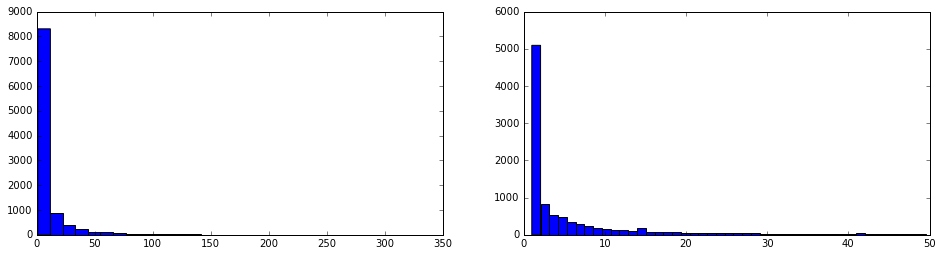

In [27]:
fig, axes = plt.subplots(1,2,figsize=(16,4))
axes[0].hist(ratings.movieId.value_counts(), bins=30)
axes[1].hist(ratings.movieId.value_counts(), bins=300)
axes[1].set_xlim(0,50)

ratings.movieId.value_counts().head() #Check minimum number of ratings per movie

C:\Users\Somil\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(64012, 3)

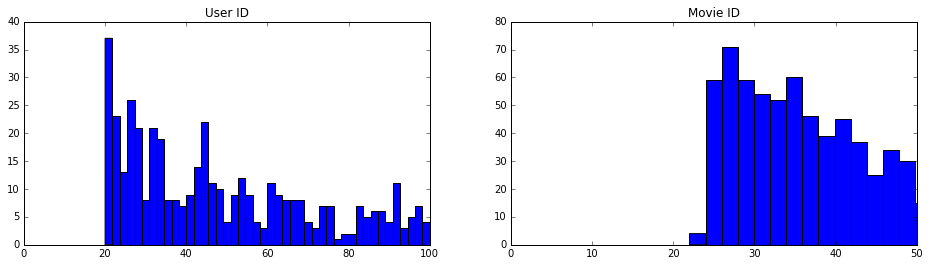

In [28]:
#Step 1: Remove movies with less ratings than threshold
r=ratings
r['movie_freq'] = r.groupby('movieId')['movieId'].transform('count')
r = r[r.movie_freq>=25]
r['user_freq'] = r.groupby('userId')['userId'].transform('count')
r = r[r.user_freq>=20]
r = r[['userId','movieId','rating']]

fig, axes = plt.subplots(1,2,figsize=(16,4))
axes[0].hist(r.userId.value_counts(), bins=500)
axes[0].set_xlim(0,100)
axes[0].set_title('User ID')
axes[1].hist(r.movieId.value_counts(), bins=150)
axes[1].set_xlim(0,50)
axes[1].set_title('Movie ID')

r.shape

In [29]:
#Step 2: Separate into training, test, cross-validation sets
#Step 3: Restructure all data sets into a matrix

same_shape = False

while same_shape == False:
    tr,test = train_test_split(r, train_size = 0.7,random_state = 0)
    #tr, ntr = train_test_split(r, train_size = 0.6)#, random_state = 0)
    #test, cv = train_test_split(ntr, train_size = 0.5)#, random_state = 0)
    trm = tr.pivot('movieId','userId','rating')
    testm = test.pivot('movieId','userId','rating')
    #cvm = cv.pivot('movieId','userId','rating')
    if trm.shape == testm.shape:
        same_shape = True
    #if (trm.shape == testm.shape) & (trm.shape==cvm.shape):
    #    same_shape = True
    
ind = trm.index
col = trm.columns

In [30]:
#Step 4: Mean Normalization on training set.
mu = trm.mean(axis = 1)
trm2 = trm.subtract(mu,axis=0)
R = np.asarray(~np.isnan(trm2)) #Matrix containing boolean for rated/not rated for each movie user pairing
trm2 = np.asarray(trm2.fillna(0))

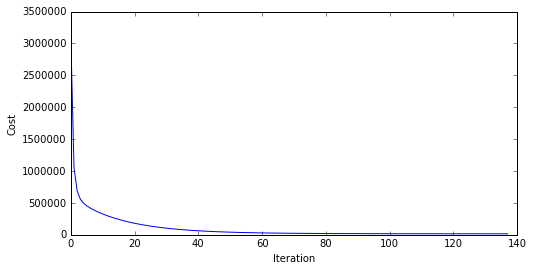

In [31]:
#Step 5: Initialize parameters for users and movies - # of parameters will be manually selected based on cross-validation accuracy
#Batch Gradient Descent
nmovies, nusers = trm2.shape
nfeatures = 100

np.random.seed(0)
X = np.random.randn(nmovies,nfeatures) #movie features
Theta = np.random.randn(nusers,nfeatures) #user features

reg = 10 #regularization parameter
alpha = .003 #learning rate

delta = 1
iter = 0
J = []
J_new = np.sum(np.sum(np.multiply(((np.dot(X,np.transpose(Theta))-trm2)**2),R)))/2 + reg/2*(np.sum(np.sum(Theta**2))+np.sum(np.sum(X**2)))
J.append({'Iteration': iter, 'Cost': J_new})
while delta >= 0.001:
    J_old = J_new
    iter = iter+1
    X_grad = np.dot(np.multiply(np.dot(X,np.transpose(Theta))-trm2,R),Theta) + reg*X
    Theta_grad = np.dot(np.transpose(np.multiply(np.dot(X,np.transpose(Theta))-trm2,R)),X)+reg*Theta
    X = X-alpha*X_grad
    Theta = Theta-alpha*Theta_grad
    J_new = np.sum(np.sum(np.multiply(((np.dot(X,np.transpose(Theta))-trm2)**2),R)))/2 + reg/2*(np.sum(np.sum(Theta**2))+np.sum(np.sum(X**2)))
    J.append({'Iteration': iter, 'Cost': J_new})
    delta = (J_old-J_new)/J_old

J= pd.DataFrame(J)
fig, axes = plt.subplots(1,1,figsize=(8,4))
axes.plot(J.Iteration, J.Cost)
axes.set_ylabel('Cost')
axes.set_xlabel('Iteration')

In [32]:
Predictions = pd.DataFrame(data = np.dot(X,np.transpose(Theta)),index = ind, columns = col)
Predictions = Predictions.add(mu,axis = 0)
Predictions2 = (Predictions*2).round()/2
n_obs= np.sum(np.sum(~np.isnan(testm)))

In [33]:
#RMSE of rating global average
RMSE_avg = math.sqrt(np.sum(np.sum((testm.subtract(mu,axis = 0))**2))/n_obs)
RMSE_avg

0.925466494054978

In [34]:
#RMSE difference of collaborative filtering algorithm
RMSE_alg = math.sqrt(np.sum(np.sum((Predictions - testm)**2))/n_obs)
RMSE_alg

0.8499824272679771

In [12]:
# %Reduction in RMSE
(RMSE_avg - RMSE_alg)/RMSE_avg*100

8.183471009187349

In [13]:
#compare to test set - Exact match accuracy
Accuracy = np.sum(np.sum(Predictions2 == testm))/n_obs
Accuracy

0.2523432618204541

In [14]:
#Compare to test set - Exact match +- 0.5 accuracy
Accuracy = (np.sum(np.sum(Predictions2 == testm)) + np.sum(np.sum(Predictions2+0.5 ==testm)) + np.sum(np.sum(Predictions2-0.5==testm)))/n_obs
Accuracy

0.6530410331181004

In [15]:
#NORMALIZED Euclidean distance from other movies based on learned features

#Normalize movie features from 0 to 1, a.k.a. Feature Scaling
X_norm = (X-X.min(axis = 0))/(X.max(axis = 0) - X.min(axis =0))

dist = []
for num1 in range(0,nmovies):
    for num2 in range(0,nmovies):
        dist.append({'movieId1': ind[num1], 'movieId2': ind[num2], 'distance':math.sqrt(np.sum((X_norm[num1]-X_norm[num2])**2))})

d = pd.DataFrame(dist)
d = d.set_index(['movieId1','movieId2'])
d = d[d.distance != 0]

In [16]:
d_mov = 1
closest = d.loc[d_mov].sort_values('distance').head(10)
print("Movies closest to %s:" %movies.loc[d_mov].title)
closest = pd.merge(closest,movies,left_index = True, right_index = True).sort_values('distance')
closest

Movies closest to Toy Story (1995):


,distance,title,genres
282,1.743107,Nell (1994),Drama
3264,1.744815,Buffy the Vampire Slayer (1992),Action|Comedy|Horror
2616,1.746264,Dick Tracy (1990),Action|Crime
1959,1.770680,Out of Africa (1985),Drama|Romance
4007,1.772630,Wall Street (1987),Drama
1960,1.775614,"Last Emperor, The (1987)",Drama
1589,1.777094,Cop Land (1997),Action|Crime|Drama|Thriller
3552,1.780252,Caddyshack (1980),Comedy
4327,1.786731,"Magnificent Seven, The (1960)",Adventure|Western
3072,1.791118,Moonstruck (1987),Comedy|Romance


In [17]:
#Dimensionality Reduction by Principal Component Analysis
#Mean normalization of features
mu2 = X.mean(axis=0)
X_norm = X-mu2
#Feature Scaling
X_proc = (X_norm-X_norm.min(axis = 0))/(X_norm.max(axis = 0) - X_norm.min(axis =0))

#PCA
ndim = 2
X_sig = np.dot(X_proc.transpose(),X_proc)/nmovies
[U,S,V] = np.linalg.svd(X_sig)
U_red = U[:,0:ndim] #Reducing to n dimensions
Z = np.dot(U_red.transpose(),X_proc.transpose()).transpose()
X_approx = np.dot(U_red,Z.transpose()).transpose()

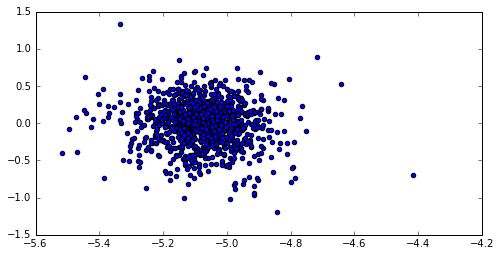

In [18]:
fig, axes = plt.subplots(1,1,figsize=(8,4))
axes.scatter(Z[:,0], Z[:,1])

In [19]:
1-np.sum((X_approx - X_proc)**2)/np.sum(X_proc**2)

0.95411414562224495

In [20]:
np.sum(S[0:ndim])/np.sum(S)

0.95411414562224506

In [23]:
#NORMALIZED Euclidean distance from other movies based on learned features

#Normalize movie features from 0 to 1, a.k.a. Feature Scaling
Z_norm = (Z-Z.min(axis = 0))/(Z.max(axis = 0) - Z.min(axis =0))

dist = []
for num1 in range(0,nmovies):
    for num2 in range(0,nmovies):
        dist.append({'movieId1': ind[num1], 'movieId2': ind[num2], 'distance':math.sqrt(np.sum((Z_norm[num1]-Z_norm[num2])**2))})

d = pd.DataFrame(dist)
d = d.set_index(['movieId1','movieId2'])
d = d[d.distance != 0]

In [24]:
d_mov = 1
closest = d.loc[d_mov].sort_values('distance').head(10)
print("Movies closest to %s:" %movies.loc[d_mov].title)
closest = pd.merge(closest,movies,left_index = True, right_index = True).sort_values('distance')
closest

Movies closest to Toy Story (1995):


,distance,title,genres
1375,0.011651,Star Trek III: The Search for Spock (1984),Action|Adventure|Sci-Fi
1801,0.014634,"Man in the Iron Mask, The (1998)",Action|Adventure|Drama
2012,0.016031,Back to the Future Part III (1990),Adventure|Comedy|Sci-Fi|Western
1569,0.018654,My Best Friend's Wedding (1997),Comedy|Romance
3489,0.019459,Hook (1991),Adventure|Comedy|Fantasy
1385,0.022210,Under Siege (1992),Action|Drama|Thriller
2699,0.024326,Arachnophobia (1990),Comedy|Horror
39,0.025571,Clueless (1995),Comedy|Romance
1042,0.028289,That Thing You Do! (1996),Comedy|Drama
1947,0.028688,West Side Story (1961),Drama|Musical|Romance
